In [ ]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas as pd
import seaborn as sns
import os

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score,KFold, StratifiedKFold, TimeSeriesSplit,GridSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read the csv file into a pandas DataFrame and append to the list
train = pd.read_csv("/content/drive/My Drive/DataScience/train_data.csv")
validation = pd.read_csv("/content/drive/My Drive/DataScience/validation_data.csv")
test = pd.read_csv("/content/drive/My Drive/DataScience/test_data.csv")
y_feature = 'windspeed'

In [ ]:
train[train.columns[0]] = pd.to_datetime(train[train.columns[0]], dayfirst=False)
test[test.columns[0]] = pd.to_datetime(test[test.columns[0]], dayfirst=False)

# Setting datetime as index
train.set_index(train.columns[0], inplace=True)
train.index.name =""
test.set_index(test.columns[0], inplace=True)
test.index.name =""
validation.set_index(validation.columns[0], inplace=True)
validation.index.name =""

# **Functions**

In [ ]:
def measure_forecast_error(label, forecast):
    '''We will use this function to measure the performance of our baseline models'''
    print('MAE = %.2f' % mean_absolute_error(label, forecast))
    print('R2 = %.2f' % r2_score(label, forecast))

def recursive_forecasting(clf, data, horizon):
    forecast = []
    for step in range(horizon):
        pred = clf.predict(data)[0]
        forecast.append(pred)
        data = np.roll(data, -1)
        data[0,-1] = pred
    return forecast

# **Establishing a Baseline Model**

Text(0, 0.5, 'windspeed')

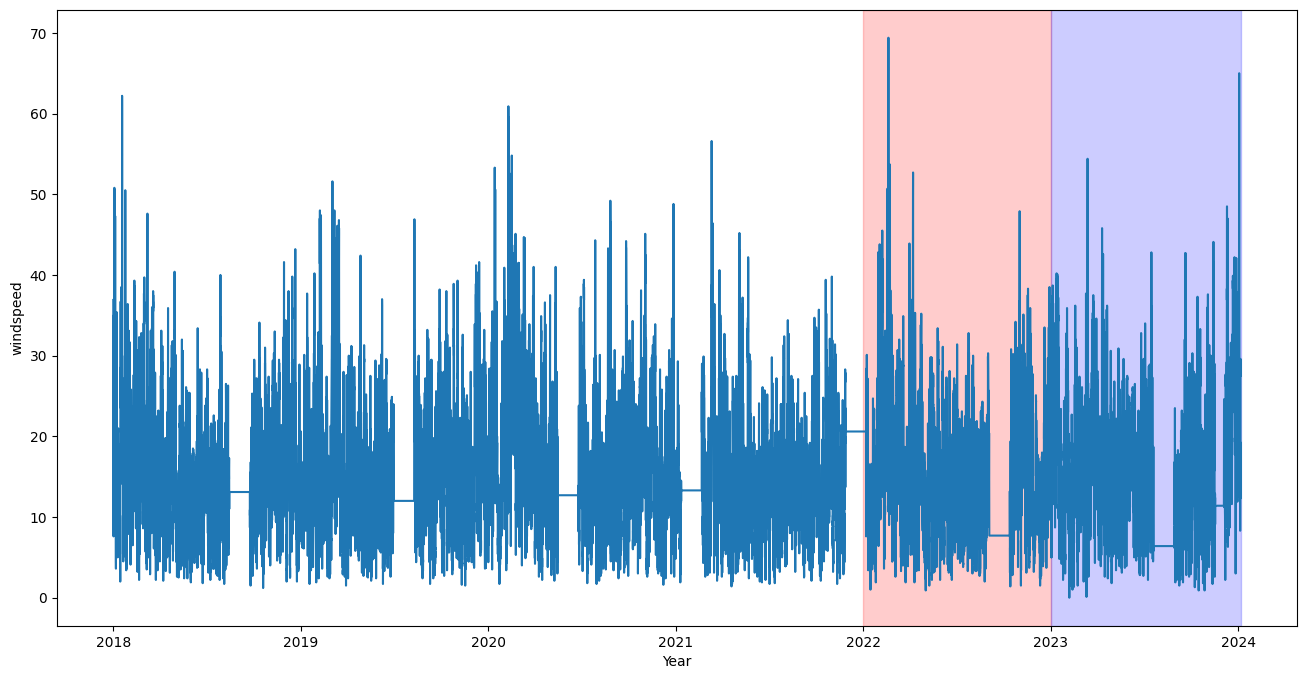

In [ ]:
merged_df = pd.concat([train,validation,test], ignore_index=False)
plt.figure(figsize=(16,8))
plt.plot(merged_df.index, merged_df[y_feature])
plt.axvspan(validation.index.min(), validation.index.max(), alpha=.2, color='red')  # validation set
plt.axvspan(test.index.min(), test.index.max(), alpha=.2, color='blue')
plt.xlabel('Year')
plt.ylabel(y_feature)

## **Last Period as Baseline**

MAE = 7.93
R2 = -0.79


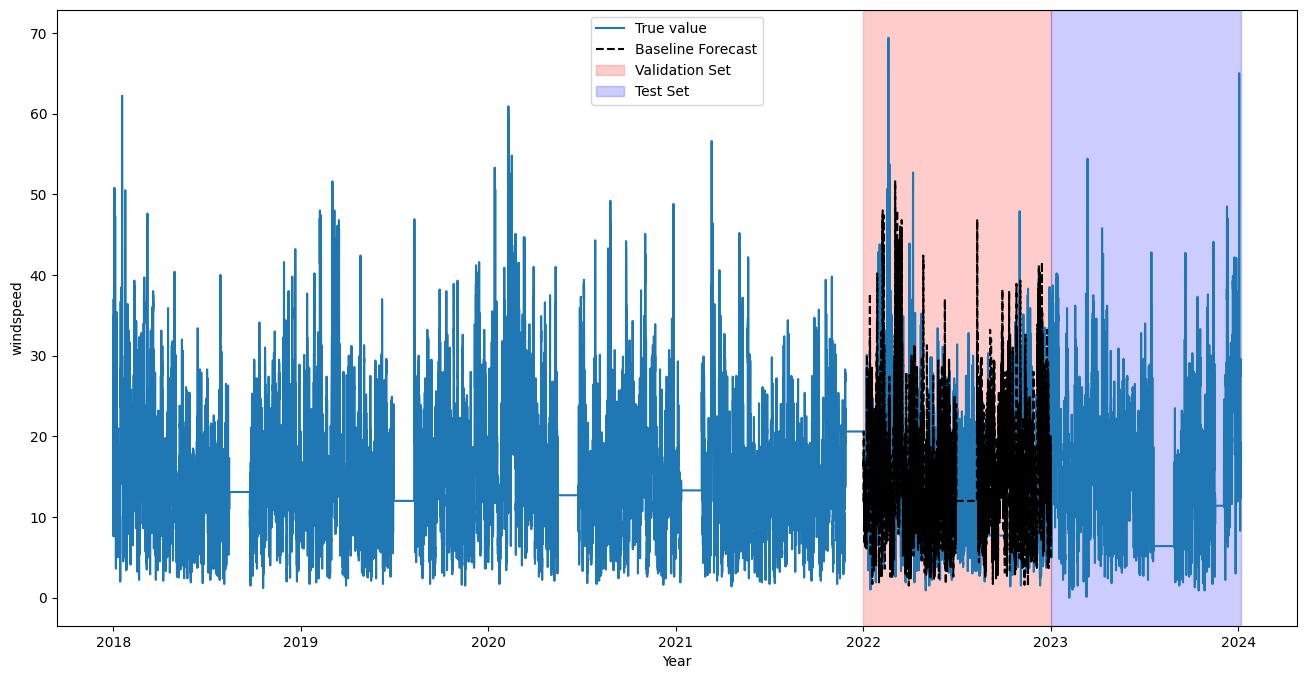

In [ ]:
# Selecting 2020 data
data_2020 = train.loc['2020']

# Removing leap year dates (February 29)
data_2020_no_leap = data_2020[~((data_2020.index.month == 2) & (data_2020.index.day == 29))]

# Taking the last 24 values
last_24_values = data_2020_no_leap[-24:]

# Assigning last 24 values to the baseline_last_period
validation['baseline_last_period'] = last_24_values.values

# Calculating forecast error
measure_forecast_error(validation[y_feature], validation['baseline_last_period'])

# validation['baseline_last_period'] = train.loc['2019'][y_feature].values
# measure_forecast_error(validation[y_feature], validation['baseline_last_period'])

dates = mdates.date2num(merged_df.index)
validation_dates = mdates.date2num(validation.index)

# Plot true values
plt.figure(figsize=(16,8))
plt.plot_date(dates, merged_df[y_feature], '-', label='True value')

# Plot baseline forecast
plt.plot_date(validation_dates, validation['baseline_last_period'], '--', label='Baseline Forecast',color='k')

# Highlight validation and test sets
plt.axvspan(validation_dates.min(), validation_dates.max(), alpha=.2, color='red', label='Validation Set')
plt.axvspan(test.index.min(), test.index.max(), alpha=.2, color='blue', label='Test Set')

plt.xlabel('Year')
plt.ylabel(y_feature)
plt.legend()
plt.show()

# **Ridge Regression (Machine Learning Model)**

**Data Preparation**

In [ ]:
# Prepare data for ML
y_feature = 'windspeed'
train = train[y_feature].to_frame()
features_to_scale = ['windspeed']

In [ ]:
scaler = MinMaxScaler()
train[features_to_scale] = scaler.fit_transform(train[features_to_scale])
validation[features_to_scale] = scaler.transform(validation[features_to_scale])
test[features_to_scale] = scaler.transform(test[features_to_scale])

In [ ]:
# Creating windows and adding lagged values
window_size = 24  # Use data from the previous day (24 hours)

for lag in range(window_size):
    train[f'{y_feature}_{lag+1}'] = train[y_feature].shift(lag+1)
    validation[f'{y_feature}_{lag+1}'] = validation[y_feature].shift(lag+1)
    test[f'{y_feature}_{lag+1}'] = test[y_feature].shift(lag+1)

# Define forecast horizon
forecast_horizon = 1  # Forecast next hour

# Define target feature
target_feature = 'y'

# Define target feature by shifting it
train[target_feature] = train[y_feature].shift(-forecast_horizon)
validation[target_feature] = validation[y_feature].shift(-forecast_horizon)
test[target_feature] = test[y_feature].shift(-forecast_horizon)

# Drop rows with NaNs due to shifting
train.dropna(inplace=True)
validation.dropna(inplace=True)
test.dropna(inplace=True)


**Implementing Grid Search for Ridge Regression**

In [ ]:
features = list(train.columns)[:-1]
def perform_grid_search(train):
    # Ridge Regression model
    model = Ridge()

    # Hyperparameter grid
    param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
    }


    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

    # Perform grid search
    grid_search.fit(train[features], train['y'])

    # Get best parameters
    best_params = grid_search.best_params_
    print("Best Parameters:", best_params)
    return best_params

# Perform grid search
best_params = perform_grid_search(train)

Best Parameters: {'alpha': 0.01}


In [ ]:
# Train the model with best parameters
best_model = Ridge(**best_params)
best_model.fit(train[features], train['y'])

# Make predictions
val_pred = best_model.predict(validation[features])

# Inverse scaling
val_pred_inverse = scaler.inverse_transform(val_pred.reshape(-1, 1)).flatten()
y_val_inverse = scaler.inverse_transform(validation['y'].values.reshape(-1, 1)).flatten()

# Calculate evaluation metric
measure_forecast_error(y_val_inverse, val_pred_inverse)

MAE = 1.48
R2 = 0.93


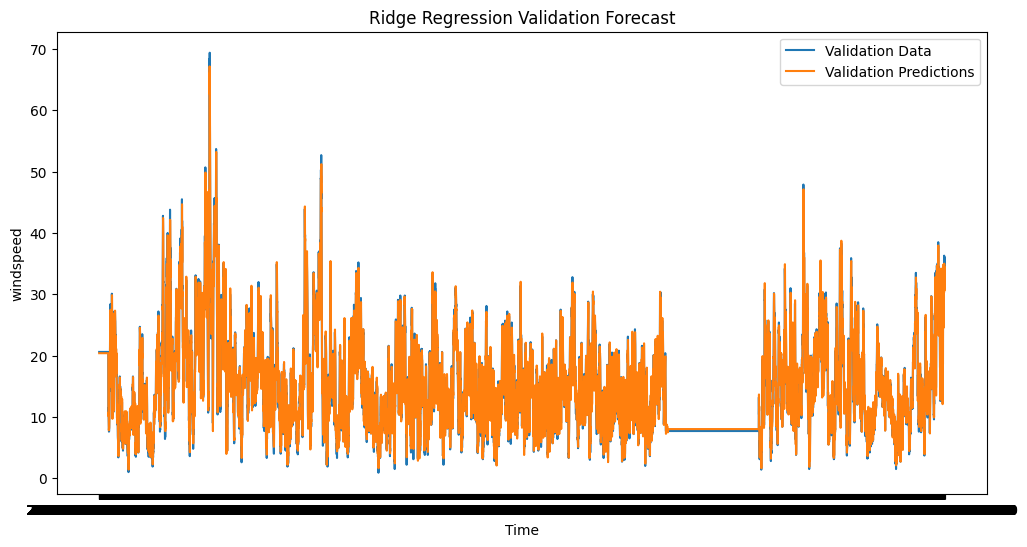

In [ ]:
# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(validation.index, y_val_inverse, label='Validation Data')
plt.plot(validation.index, val_pred_inverse, label='Validation Predictions')
plt.xlabel('Time')
plt.ylabel(y_feature)
plt.title('Ridge Regression Validation Forecast')
plt.legend()
plt.show()

In [ ]:
# Make predictions
test_pred = best_model.predict(test[features])

# Inverse scaling
test_pred_inverse = scaler.inverse_transform(test_pred.reshape(-1, 1))
y_test_inverse = scaler.inverse_transform(test['y'].values.reshape(-1, 1))

# Calculate evaluation metric
measure_forecast_error(y_test_inverse, test_pred_inverse)

MAE = 1.51
R2 = 0.93


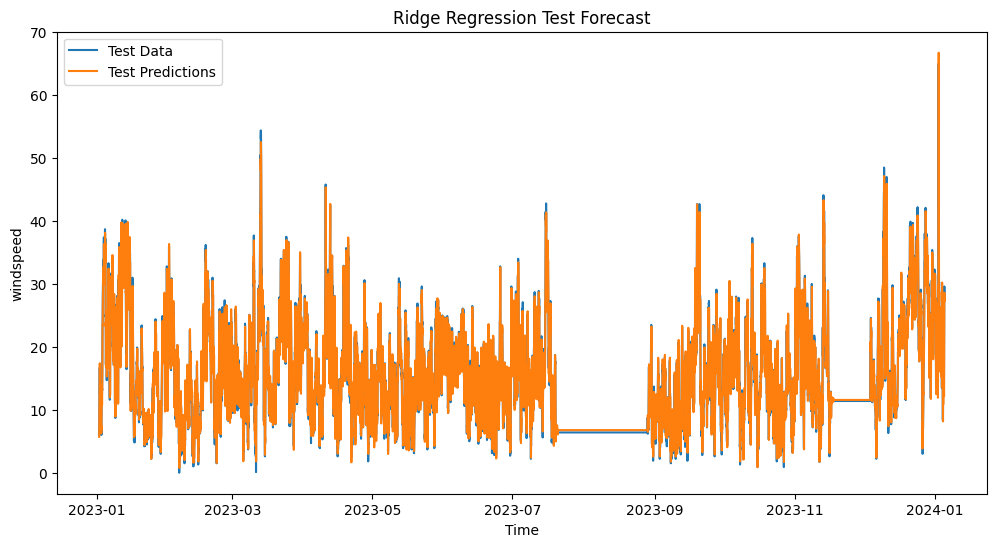

In [ ]:
# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test_inverse, label='Test Data')
plt.plot(test.index, test_pred_inverse, label='Test Predictions')
plt.xlabel('Time')
plt.ylabel(y_feature)
plt.title('Ridge Regression Test Forecast')
plt.legend()
plt.show()

# **Assumptions**

As per Research and understanding I have made below assumptions:

Annual Electricity use(Kwh) in uk

Low: 1800
Medium: 2700
High: 4100

Formula:
Power = 0.5 x Swept Area x Air Density x Velocity3


Refrences:
https://www.ofgem.gov.uk/information-consumers/energy-advice-households/average-gas-and-electricity-use-explained
https://www.ovoenergy.com/guides/energy-guides/how-much-electricity-does-a-home-use
http://www.reuk.co.uk/wordpress/wind/calculation-of-wind-power/


In [ ]:
required_energy = 320  # kW
blade_length_meters = 50
threshold_energy = required_energy * 3  # kW
air_density_kg_per_m3 = 1.2
number_of_turbines = 20
def calculate_wind_energy_by_row(row):
    return calculate_wind_energy_assumption(row['windspeed'])
def calculate_wind_energy_assumption(wind_speed):
    wind_speed_m_per_s = wind_speed
    swept_area_m2 = blade_length_meters * 3.14
    # Converting speed into m/s
    wind_speed_m_per_s = wind_speed_m_per_s / 3.6
    # Calculating wind energy
    power_kw = 0.5 * air_density_kg_per_m3 * swept_area_m2 * (wind_speed_m_per_s) ** 3
    total_wind_power_kw = number_of_turbines * power_kw
    return total_wind_power_kw / 1000  # Convert to kW



**Forecasting 24 hours ahead on Test data**

In [ ]:
forecasted_windspeed = []
forecasted_energy = []
for i in range(len(test)-24):
  forecasted_values= recursive_forecasting(clf=best_model, data=test[features].values[i,:].reshape(1, -1),  horizon=24)
  ws = scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1))[-1]
  forecasted_windspeed.append(ws)
  forecasted_energy.append(calculate_wind_energy_assumption(ws))

**Calculating actual wind energy**

In [ ]:
test['y'] = scaler.inverse_transform(np.array(test['y']).reshape(-1, 1))
test['wind_energy_assumption'] = test.apply(calculate_wind_energy_by_row, axis=1)

In [ ]:
len(test)

8841

In [ ]:
len(test) - len(forecasted_windspeed)

24

In [ ]:
measure_forecast_error(test[:-48]['y'],forecasted_windspeed[24:])

MAE = 0.58
R2 = 0.99


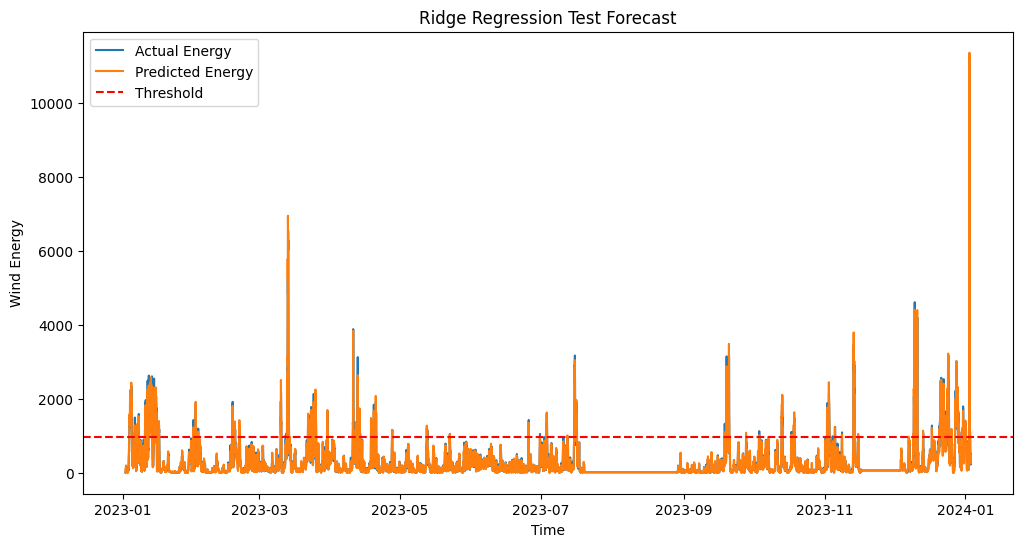

In [ ]:
# Plotting wind energy
plt.figure(figsize=(12, 6))
val = 48

plt.plot(test[:-val].index, test[:-val]['wind_energy_assumption'], label='Actual Energy')
plt.plot(test[:-val].index, forecasted_energy[24:], label='Predicted Energy')
plt.axhline(y=threshold_energy, color='r', linestyle='--', label='Threshold')
plt.xlabel('Time')
plt.ylabel("Wind Energy")
plt.title('Ridge Regression Test Forecast')
plt.legend()
plt.show()

In [ ]:
# Calculating R2 value for each month
test_data = test[:-val]
predictions = forecasted_windspeed[24:]
R2_values = []

# Calculate R2 value for each month
for month in range(12):
    true_value = test_data.loc['2023-' + str(month + 1)]['windspeed']
    end_idx = len(true_value)
    pred_value = predictions[:end_idx]
    predictions = predictions[end_idx:]
    R2_values.append(r2_score(true_value, pred_value))

print(R2_values)


[0.9208870363060424, 0.8982480876198186, 0.8919813697632714, 0.8872172561374533, 0.8573685802750864, 0.8337268533890295, 0.9363613128557494, 0.8552085126862846, 0.8820720168898921, 0.8694933402966784, 0.9163829248321015, 0.9289466781458804]


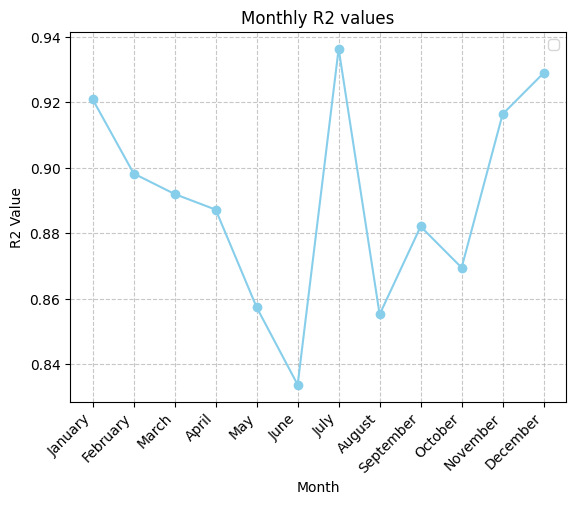

In [ ]:
#  months
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Plot the R2 Values with months
plt.plot(months, R2_values, marker='o', color='skyblue', linestyle='-')
plt.xlabel('Month')
plt.ylabel('R2 Value')
plt.title('Monthly R2 values')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()


By looking at the R2 monthly plot, we can say that our model is performing good in every month.